# Time-Stealed, or how social medias are stealing our lives

_Year 2025, a great portion of our lives is experienced within a virtual environment where we can access an infinite stream of information that excites our brain and that pleasures it with rivers of dopamine. The speed, the bright colors, the catchy audios and the enraging news, everything has been carefully engineered to keep us trapped in front of a glowy screen_

Told like this it might sound like the incipit of a cyberpunk novel, but it's actually not that far from our reality, is it? The virtual environments I'm talking about are obviously social medias, that despite all they've done for the free circulation of information, have a scary dark side.

The aim of this project is to shed a light on that side and investigate where does our time go and why it seems so difficult to put a stop to a now far too common habbit: doomscrolling.

But why should social medias be implemented to keep us on their platforms? To understand this, it's important to clarify what is their business model. Social medias' profit originates primarely from the "attention economy", in other words, they make money by showing tertiary companies' adds to their user base (and by selling their data, but that is a whole other story). So, when the content you're consuming is suddently interrupted by an ad, the attention economy has completed its circle: a company made its attempt to convince you to buy their product and the hosting platform made its share. The follow-up question is then, how does the social media of the situation boosts its revenue? Simple, it tries to maximise the exposure time and the engagement of the user. And how does it do it? With a plethora of sophisticated [psychological tricks](https://www.youtube.com/watch?v=uaaC57tcci0) that hook the user's attention for [hours](https://www.statista.com/statistics/433871/daily-social-media-usage-worldwide/) on end.

Note: personal considerations will be highlighted in bold characters

## Table of Contents
* Imports and utility functions
* Dataset
* Bayesian network
    * Variables
    * Correlation matrix
    * Structure learning and analysis
        * PC algorithm (constraint-based)
        * Tree search (score-based)
    * Structure definition and analysis
* Inferences
* Conclusions
* References

## 0. Imports and utility functions

In [142]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.estimators import PC, TreeSearch
from sklearn.preprocessing import LabelEncoder

In [143]:
# Suppresses warnings
import warnings
warnings.filterwarnings('ignore')

In [144]:
# Visualizes the given model with the given title
def visualize_model(model, title):
    graph = nx.DiGraph(model.edges)
    plt.figure(figsize=(12, 6))
    nx.draw_circular(G=graph, with_labels=True, node_size=4000, node_color="#8621ff", arrowsize=20, font_size=8)
    plt.title(title)
    plt.show()

In [145]:
# Analyzes the structure of the Bayesian Network
def analyze_model(model, model_name):
    print(model_name.upper())
    print(f"\nD-separations: {model.get_independencies().get_assertions()}")
    print(f"\nImmoralities: {model.get_immoralities()}") # TODO should I include ALL v-structures?
    for n in model.nodes:
        print(f"\n{n}")
        print(f"Local semantics: {model.local_independencies(n)}")
        print(f"Markov blanket: {model.get_markov_blanket(n)}")
    print()

## 1. Dataset
This project leverages bayesian networks to extract interesting patterns from the dataset [Dark Side Of Social Media](https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media?resource=download). This dataset has been generated via synthetic data generation tecniques to simulate real-world social media usage patterns (read the [EDA](https://www.kaggle.com/code/waqi786/in-depth-analysis-of-time-wasters-on-social-media) for further details).

In [146]:
# Loads and previews the dataset and its shape
data = pd.read_csv('Time-Wasters on Social Media.csv', delimiter=',')
print(f'Shape: {data.shape}')
data.head()

Shape: (1000, 31)


,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


## 2. Bayesian network

### 2.1 Variables
The dataset contains many variables spanning from the characteristics of the users to the features of their device. However, for the purpose of this project - which focuses on the time spent on social medias due to their addictive traits - only 10 out of 31 columns have been selected.

In [147]:
# Selects only relevant columns
selected_data = data[['Watch Reason', 'Platform', 'Addiction Level', 'Self Control', 'Importance Score', 'Engagement', 'Scroll Rate', 'Total Time Spent', 'ProductivityLoss', 'Satisfaction']]

# Renames the selected columns for clarity
selected_data.loc[:, 'ProductivityLoss'].apply(lambda x: 10 - x)
selected_data.columns = ['Reason', 'Platform', 'Addiction', 'Intentionality', 'Importance', 'Engagement', 'Context-Switch', 'Time', 'Productivity', 'Satisfaction']
selected_data.index = data.UserID.values
selected_data.head()

,Reason,Platform,Addiction,Intentionality,Importance,Engagement,Context-Switch,Time,Productivity,Satisfaction
1,Procrastination,Instagram,5,5,5,7867,87,80,3,7
2,Habit,Instagram,3,7,6,5944,46,228,5,5
3,Entertainment,Facebook,2,8,3,8674,88,30,6,4
4,Habit,YouTube,5,5,2,2477,93,101,3,7
5,Boredom,TikTok,0,10,7,3093,4,136,8,2


Here is a brief descriprion of them:

- Reason: the reason why the users entered the platform.

- Platform: the social media platform chosen by the users.

- Addiction: the addiction level of the users to social medias.

- Intentionality: the intentionality level that lead the users to enter the platform.

- Importance: the importance assigned by the users to the content.

- Engagement: the engagement level of the users with the content.

- Context-Switch: how quickly the users switch from one piece of content to the next.

- Time: the total amount of time that the users have spent on the platform.

- Productivity: the productivity level of the users during the content consumption.

- Satisfaction: the satisfaction level of the users at the end of the content consumption.

### 2.2 Correlation matrix
Before building the Bayesian Network it can be usefull to look at the correlation matrix to gather some information about the relationships between the selected variables. Given that the correlation matrix only works with numerical variables, the categorical ones have been label-encoded, meaning that each string-value that a variable could take has been univocally mapped into an integer. This encoding has been preferred to the one-hot-encoding for readibility reasons.

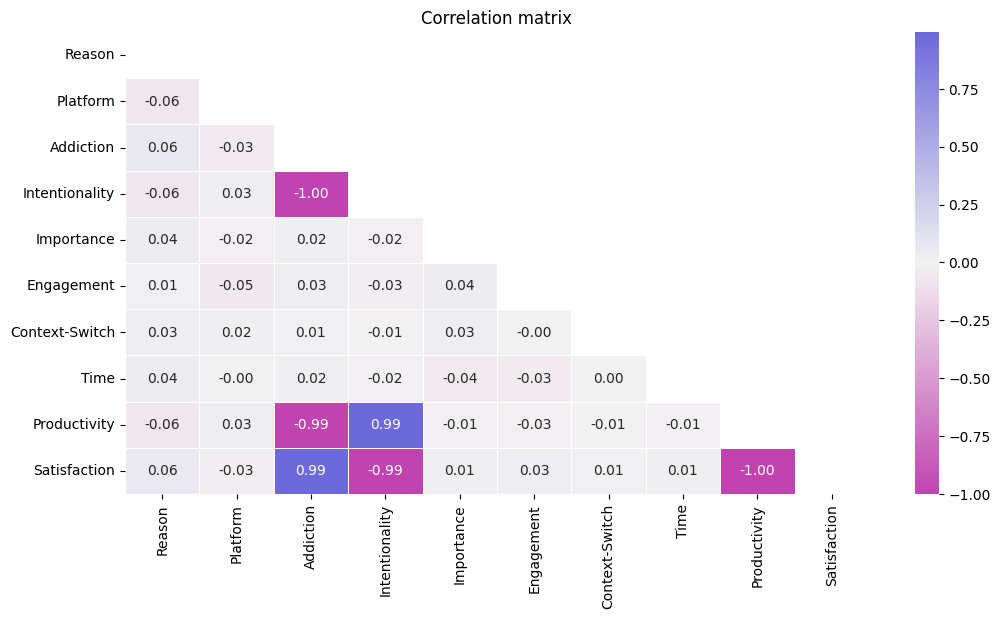

In [148]:
# Encodes the categorical columns with a label-encoder
label_encoder = LabelEncoder()
categorical_columns = selected_data.select_dtypes(include='object').columns
encoded_data = selected_data.copy()
for c in categorical_columns:
    encoded_data[c] = label_encoder.fit_transform(selected_data[c])

# Computes the correlation matrix
correlation_matrix = encoded_data.corr(method='pearson')

# Visualizes the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.diverging_palette(316, 267, as_cmap=True), fmt=".2f", linewidths=.5, mask=mask)
plt.title('Correlation matrix')
plt.show()

From the above graph we can already make three considerations:
1. most variables are poorly correlated of eachother, so they are basically independent
2. some variables (Addiction-Intentionality, Productivity-Satisfaction) are inversly correlated of eachother, so they represent basically the same concept
3. some variables (Satisfaction, Productivity, Intentionality, Addiction) are interestingly correlated of eachother but also unexpectedly isolated from other ones

The dataset used was synthetically produced and **I suspect that for that reason it might not precisely reflect reality**

### 2.3 Structure learning and analysis
Structure learning is a data-driven process to estimate the structure of a Bayesian Network from the available data. For this project both the constraint-based and score-based approach have been put to the test

#### 2.3.1 PC algorithm (constraint-based)
This Bayesian Network was obtained by applying the PC algorithm. This tecnique inserts one variable at a time and adds a link between the new variable and the old ones only if they are conditionally dependent of eachother

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Addiction': 'N', 'Intentionality': 'N', 'Importance': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Productivity': 'N', 'Satisfaction': 'N'}


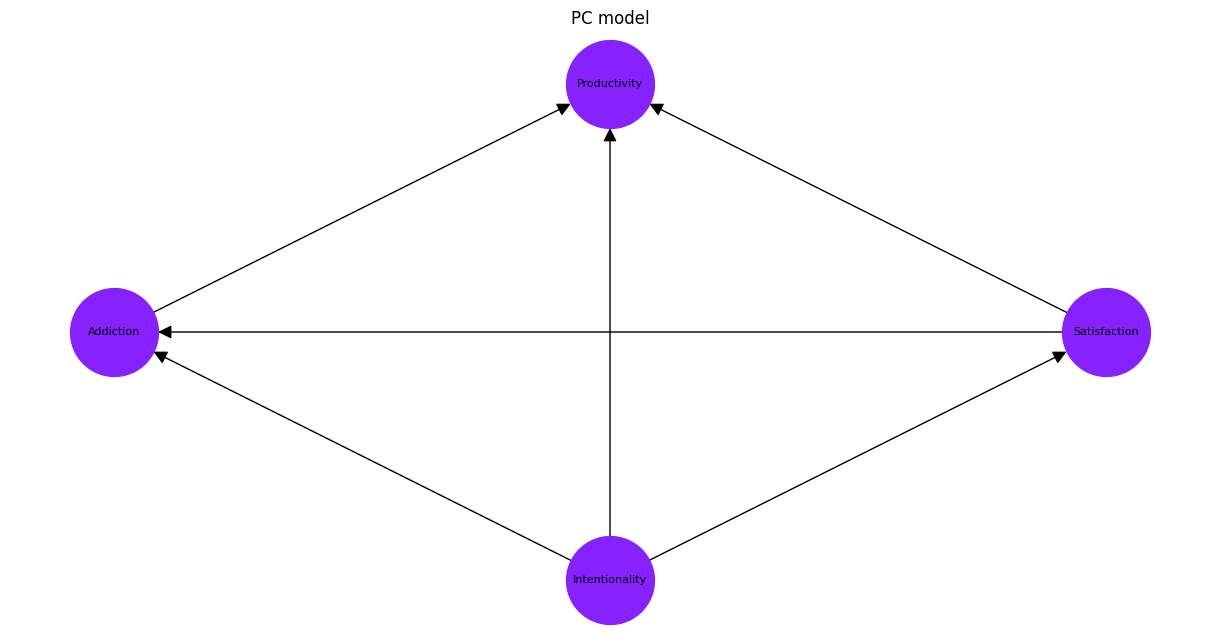

In [149]:
# Estimates the structure of the Bayesian Network from the selected data
pc_estimator = PC(data=selected_data)
pc_model = pc_estimator.estimate(show_progress=False, return_type="dag")
visualize_model(model=pc_model, title="PC model")

In [150]:
analyze_model(model=pc_model, model_name="PC model")

PC MODEL

D-separations: [(Importance ⟂ Productivity), (Time ⟂ Productivity), (Importance ⟂ Intentionality), (Addiction ⟂ Reason), (Engagement ⟂ Reason), (Satisfaction ⟂ Platform), (Engagement ⟂ Satisfaction), (Satisfaction ⟂ Reason), (Time ⟂ Intentionality), (Addiction ⟂ Platform), (Importance ⟂ Reason), (Engagement ⟂ Importance), (Time ⟂ Context-Switch), (Addiction ⟂ Importance), (Time ⟂ Addiction), (Time ⟂ Importance), (Productivity ⟂ Platform), (Time ⟂ Platform), (Context-Switch ⟂ Importance), (Reason ⟂ Productivity), (Context-Switch ⟂ Reason), (Context-Switch ⟂ Productivity), (Context-Switch ⟂ Platform), (Time ⟂ Engagement), (Time ⟂ Reason), (Addiction ⟂ Engagement), (Addiction ⟂ Context-Switch), (Context-Switch ⟂ Intentionality), (Importance ⟂ Platform), (Intentionality ⟂ Platform), (Intentionality ⟂ Reason), (Context-Switch ⟂ Engagement), (Reason ⟂ Platform), (Engagement ⟂ Productivity), (Context-Switch ⟂ Satisfaction), (Importance ⟂ Satisfaction), (Engagement ⟂ Intentionality),

#### 2.3.2 Tree search (score-based)
This Bayesian Network was obtained by applying the Tree Search algorithm. This tecnique uses the Chow-Liu algorithm and the TAN algorithm to estimate a tree-like structure from the selected data.

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Addiction': 'N', 'Intentionality': 'N', 'Importance': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Productivity': 'N', 'Satisfaction': 'N'}


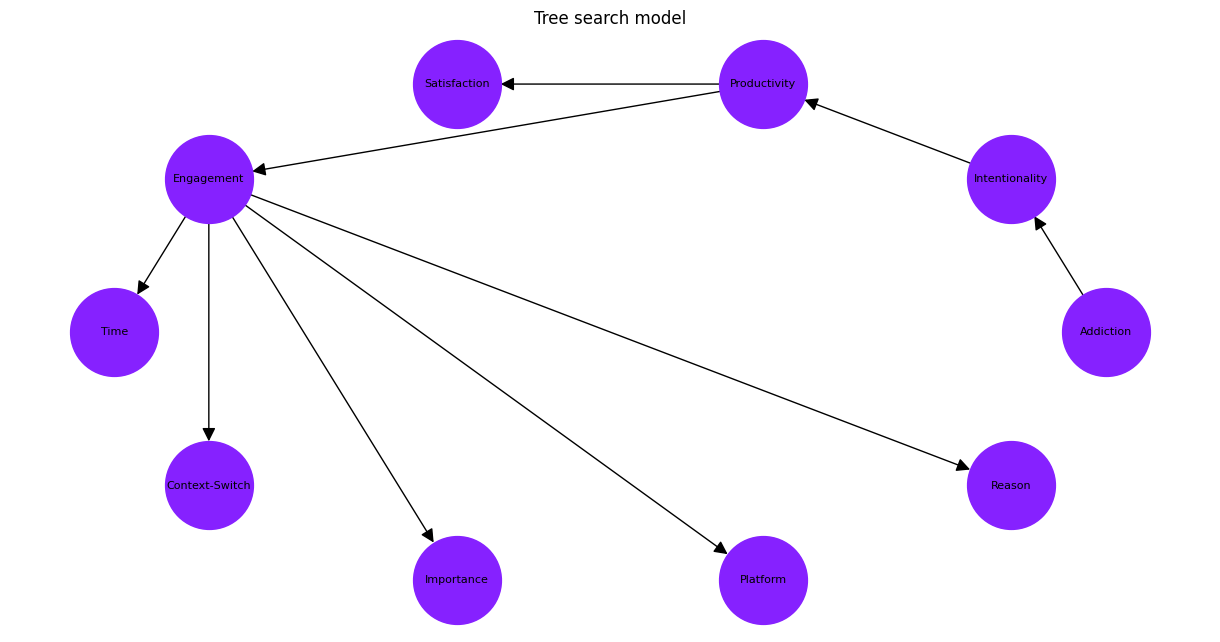

In [151]:
ts_estimator = TreeSearch(selected_data, root_node='Addiction')
ts_model = ts_estimator.estimate(show_progress=False)
visualize_model(model=ts_model, title="Tree search model")

In [152]:
analyze_model(model=ts_model, model_name="Tree search model")

TREE SEARCH MODEL

D-separations: [(Addiction ⟂ Engagement | Productivity), (Importance ⟂ Reason | Engagement), (Satisfaction ⟂ Intentionality | Productivity), (Time ⟂ Context-Switch | Engagement), (Time ⟂ Addiction | Engagement), (Productivity ⟂ Platform | Engagement), (Addiction ⟂ Importance | Engagement), (Time ⟂ Platform | Engagement), (Time ⟂ Importance | Engagement), (Reason ⟂ Productivity | Engagement), (Context-Switch ⟂ Reason | Engagement), (Context-Switch ⟂ Satisfaction | Productivity), (Context-Switch ⟂ Platform | Engagement), (Importance ⟂ Satisfaction | Productivity), (Context-Switch ⟂ Importance | Engagement), (Context-Switch ⟂ Productivity | Engagement), (Engagement ⟂ Intentionality | Productivity), (Addiction ⟂ Context-Switch | Engagement), (Time ⟂ Reason | Engagement), (Time ⟂ Satisfaction | Productivity), (Context-Switch ⟂ Intentionality | Engagement), (Importance ⟂ Platform | Engagement), (Intentionality ⟂ Platform | Engagement), (Satisfaction ⟂ Platform | Productivi

### 2.4 Structure definition and analysis
This Bayesian Network has been build by adding variables one by one following this order:

Reason -> Platform -> Addiction -> Intentionality -> Importance -> Engagement -> Context-Switch -> Time -> Productivity -> Satisfaction

At each step, a link between the new variable and the old ones is added according to these considerations:

- Reason
- Platform
- Addiction
    - Platform -> Addiction: addiction depends on platform as certain platforms are more addictive than others
    - Reason -> Addiction: addiction depends on reason as compulsive behaviours are triggered by specific situations
- Intentionality
    - Addiction -> Intentionality: intentionality depends on addiction as compulsive behaviours are little intentional by definition
- Importance
    - Reason -> Importance: importance depends on reason as social medias can be used for different purposes
- Engagement
    - Importance -> Engagement: engagement depends on importance as compelling content is more engaging
- Context-Switch
    - Importance -> Context-Switch: context-switch depends on importance as compelling content retains users' attention more
    - Platform -> Context-Switch: context-switch depends on platform as different platforms have different content formats
- Time
    - Engagement -> Time: time depends on engagement as active tasks are more rewarding
    - Addiction -> Time: time depends on addiction as quitting a compulsive behaviour is hard by definition
- Productivity
    - Importance -> Productivity: productivity depends on importance as consuming compelling content can be productive
    - Intentionality -> Productivity: productivity depends on intentionality as unintentional behaviours rarely allign with users' goals
- Satisfaction
    - Intentionality -> Satisfaction: satisfaction depends on intentionality as intentionally achieving a goal is satisfying

In [153]:
# Defines the BN
custom_bn = DiscreteBayesianNetwork([
    ('Platform', 'Addiction'),
    ('Reason', 'Addiction'),
    ('Addiction', 'Intentionality'),
    ('Reason', 'Importance'),
    ('Importance', 'Engagement'),
    ('Importance', 'Context-Switch'),
    ('Platform', 'Context-Switch'),
    ('Engagement', 'Time'),
    ('Addiction', 'Time'),
    ('Importance', 'Productivity'),
    ('Intentionality', 'Productivity'),
    ('Intentionality', 'Satisfaction')
])

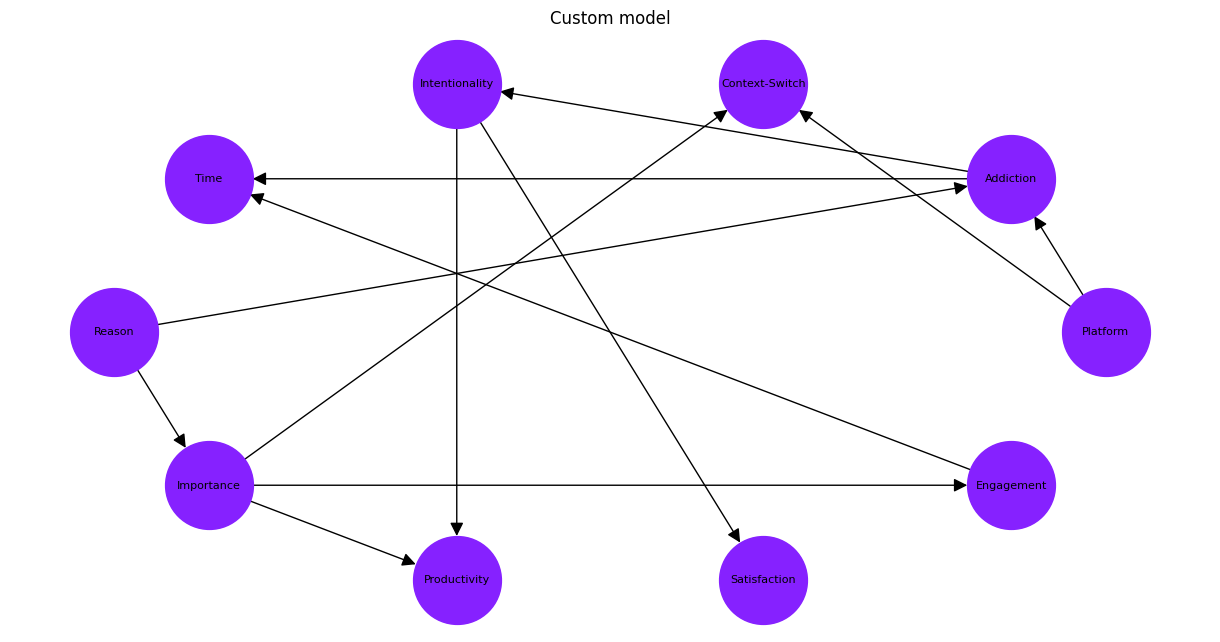

In [154]:
visualize_model(custom_bn, "Custom model")

In [155]:
analyze_model(custom_bn, "Custom model")

CUSTOM MODEL

D-separations: [(Intentionality ⟂ Reason | Addiction), (Addiction ⟂ Engagement | Reason), (Time ⟂ Importance | Reason, Engagement), (Time ⟂ Context-Switch | Importance, Platform), (Time ⟂ Platform | Addiction, Engagement), (Engagement ⟂ Context-Switch | Importance), (Time ⟂ Productivity | Intentionality, Importance), (Engagement ⟂ Productivity | Importance), (Engagement ⟂ Intentionality | Importance), (Satisfaction ⟂ Context-Switch | Intentionality), (Importance ⟂ Satisfaction | Reason), (Time ⟂ Reason | Addiction, Engagement), (Engagement ⟂ Reason | Importance), (Time ⟂ Satisfaction | Intentionality), (Intentionality ⟂ Context-Switch | Importance, Platform), (Time ⟂ Intentionality | Addiction), (Importance ⟂ Intentionality | Reason), (Engagement ⟂ Satisfaction | Importance), (Satisfaction ⟂ Platform | Intentionality), (Productivity ⟂ Platform | Intentionality, Importance), (Satisfaction ⟂ Reason | Intentionality), (Productivity ⟂ Reason | Intentionality, Importance), (Pr

## 3. Inferences

The inferences will investigate low/high levels of *place_holder*, so it is necessary to define some thresholds:

- High addictiveness: > 5 (assuming the scale is 1-10)

- High intentionality: > 5 (assuming the scale is 1-10)

- High importance: > 5 (assuming the scale is 1-10)

- High engagement: > 500 (assuming the scale is 1-1000)

- High context-switch: > 50 (assuming the scale is 1-100)

- Long time: > 30 (assuming min as the unit of measurement)

- High productivity: > 5 (assuming the scale is 1-10)

- High satisfaction: > 5 (assuming the scale is 1-10)

Assumptions on scales and units of measurement are necessary as the dataset description lacks the needed details. However, it was possible to extract the following information about the domains of the variables:

In [156]:
# Prints the domain of each variable:
for c in selected_data.columns:
    domain = selected_data[c].unique()
    if domain.dtype == "int64":
        print(f"Domain of {c}: [min: {domain.min()}, max: {domain.max()}]")
    else:
        print(f"Domain of {c}: {domain}")

Domain of Reason: ['Procrastination' 'Habit' 'Entertainment' 'Boredom']
Domain of Platform: ['Instagram' 'Facebook' 'YouTube' 'TikTok']
Domain of Addiction: [min: 0, max: 7]
Domain of Intentionality: [min: 3, max: 10]
Domain of Importance: [min: 1, max: 9]
Domain of Engagement: [min: 15, max: 9982]
Domain of Context-Switch: [min: 1, max: 99]
Domain of Time: [min: 10, max: 298]
Domain of Productivity: [min: 1, max: 9]
Domain of Satisfaction: [min: 1, max: 9]


In [157]:
# Converts the DAGs into DiscreteBayesianNetwork objects
pc_bn = DiscreteBayesianNetwork(pc_model)
ts_bn = DiscreteBayesianNetwork(ts_model)

bayesian_networks = [pc_bn, ts_bn, custom_bn]

# Fits the data into the BNs to learn the CPTs (a CPT is a table that specifies the probability of each value of a variable for every combination of values of its parents)
for bn in bayesian_networks:
    bn.cpds = []
    bn.fit(selected_data)

# # The printing of the CPTs has been commented out as it took too much space
# for m in bayesian_networks:
#     for cpd in m.get_cpds():
#         print('CPT of {}'.format(cpd.variable))
#         print(cpd, '\n')

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Addiction': 'N', 'Intentionality': 'N', 'Importance': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Productivity': 'N', 'Satisfaction': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Addiction': 'N', 'Intentionality': 'N', 'Importance': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Productivity': 'N', 'Satisfaction': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Reason': 'C', 'Platform': 'C', 'Addiction': 'N', 'Intentionality': 'N', 'Importance': 'N', 'Engagement': 'N', 'Context-Switch': 'N', 'Time': 'N', 'Productivity': 'N', 'Satisfaction': 'N'}


In [158]:
# # Initializes the variable eliminators
# pc_variable_eliminator = VariableElimination(pc_bn)
# ts_variable_eliminator = VariableElimination(ts_bn)
# custom_variable_eliminator = VariableElimination(custom_bn)

# # TODO this must be defined for each model
# # Defines the states of interest
# long_time_states_custom = [s for s in custom_bn.states['Time'] if s > 30]
# low_intentionality_states_custom = [s for s in custom_bn.states['Intentionality'] if s <= 5]
# low_satisfaction_states_custom = [s for s in custom_bn.states['Satisfaction'] if s <= 5]
# high_addiction_states_custom = [a for a in custom_bn.states]

memoization = {}

### 3.1 What is the probability that an addicted user has long sessions?

In [159]:
def exact_inference_1(bn):
    variable_eliminator = VariableElimination(bn)
    high_addiction_states = [s for s in bn.states['Addiction'] if s > 5]
    
    # P(T>30,A>5)
    p_d_of_t_and_a = variable_eliminator.query(variables=['Time', 'Addiction'], joint=True)
    p_of_long_t_and_high_a = 0
    for t in [s for s in bn.states['Time'] if s > 30]:
        for a in high_addiction_states:
            p_of_long_t_and_high_a += p_d_of_t_and_a.get_value(**{'Time':t, 'Addiction':a})
            
    # P(A>5)
    p_d_of_a = variable_eliminator.query(variables=['Addiction'])
    p_of_high_a = 0
    for a in high_addiction_states:
        p_of_high_a += p_d_of_a.get_value(**{'Addiction':a})
    memoization["p_of_high_a"] = p_of_high_a

    # P(T>30|A>5) = P(T>30,A>5)/P(A>5)
    return p_of_long_t_and_high_a/p_of_high_a

In [160]:
print(f"PC: {exact_inference_1(pc_bn)}")
print(f"TS: {exact_inference_1(ts_bn)}")
print(f"CUSTOM: {exact_inference_1(custom_bn)}")

PC: 0.9199999999999972
TS: 0.988764044943821
CUSTOM: 0.9270132566583071


#### Considerations
All models show that it is very likely that an addicted user has a long session. **Recalling social medias' business model (see introduction), I think that companies are incentivised to make their platform as addictive as possible because it boosts users' screen time significantly.**

### 3.2 What is the probability that an addicted user has unproductive sessions?

In [161]:
def exact_inference_2(bn):
    variable_eliminator = VariableElimination(bn)
    low_productivity_states = [s for s in bn.states['Productivity'] if s <= 5]
    high_addiction_states = [s for s in bn.states['Addiction'] if s > 5]

    # P(P<=5,A>5)
    p_d_of_p_and_a = variable_eliminator.query(variables=['Productivity', 'Addiction'], joint=True)
    p_of_low_p_and_high_a = 0
    for p in low_productivity_states:
        for a in high_addiction_states:
            p_of_low_p_and_high_a += p_d_of_p_and_a.get_value(**{'Productivity':p, 'Addiction':a})

    # P(P<=5|A>5) = P(P<=5,A>5)/P(A>5)
    return p_of_low_p_and_high_a/memoization["p_of_high_a"]

In [162]:
print(f"PC: {exact_inference_2(pc_bn)}")
print(f"TS: {exact_inference_2(ts_bn)}")
print(f"CUSTOM: {exact_inference_2(custom_bn)}")

PC: 0.9936625243872044
TS: 0.9936625243872044
CUSTOM: 0.9999999999999999


#### Considerations
All models show that it is basically certain that an addicted user has an unproductive session.

### 3.3 What is the probability that an addicted user has unsatisfying sessions?

In [163]:
def exact_inference_3(bn):
    variable_eliminator = VariableElimination(bn)
    low_satisfaction_states = [s for s in bn.states['Satisfaction'] if s <= 5]
    high_addiction_states = [s for s in bn.states['Addiction'] if s > 5]

    # P(S<=5,A>5)
    p_d_of_s_and_a = variable_eliminator.query(variables=['Satisfaction', 'Addiction'], joint=True)
    p_of_low_s_and_high_a = 0
    for s in low_satisfaction_states:
        for a in high_addiction_states:
            p_of_low_s_and_high_a += p_d_of_s_and_a.get_value(**{'Satisfaction':s, 'Addiction':a})

    # P(S<=5|A>5) = P(S<=5,A>5)/P(A>5)
    return p_of_low_s_and_high_a/memoization["p_of_high_a"]

In [164]:
print(f"PC: {exact_inference_3(pc_bn)}")
print(f"TS: {exact_inference_3(ts_bn)}")
print(f"CUSTOM: {exact_inference_3(custom_bn)}")

PC: 0.0
TS: 0.0
CUSTOM: 0.0


#### Considerations

All models show that an addicted user has never an unsatisfying session.

## 4. Conclusions
In the early years of 2000 the world of communication was revolutionized by the advent of social medias. Since then, our society started to change in ways we are beginning to understand only now. These tools spread quickly due to valueable applications like:
- effective networking
- creativity expression
- unfiltered sharing of information
- creation of businesses
- access to educational materials

Soon after though, negatives consequences emerged as well:
- cyberbullying
- mental health degradation
- doxxing
- privacy concerns
- digital survaillance
Among these, there is also addiction, which was the primary focus of this study. 

From the few inferences made it seems that... TODO

**I hereby express my concern for my generation and the ones to come if the dark sides of our beloved social medias won't be addressed effectively**

# References

- approximate inference
- benchmarks

Io: "Oggi sono stata al telefono 6 ore, ma com'è possibile? Voi raga? Non ditemi che sono l'unica"

F: "A me di solito segna 5"

...